In [3]:
# Импорт библиотек
import pandas as pd
import numpy as np

from funcs import *

from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# Загрузка датасета
df = pd.read_excel('proc_db3.xlsx')
df.head()

,Material,Shape,Coat/Functional Group,Synthesis_Method,Diameter (nm),Size_in_Water (nm),Size_in_Medium (nm),Zeta_in_Water (mV),Zeta_in_Medium (mV),Cell_Type,...,Cell_Morphology,Cell_Age,Cell Line_Primary Cell,Time (hr),Concentration (ug/ml),Test,Test_Indicator,Aspect_Ratio,Cell_Viability (%),is_inorganic
0,SiO2,Sphere,CTAB,Precipitation,21.06,386.9,90.09,-35.9,-28.0,PC12,...,Irregular,Adult,L,12,1.95,MTT,TetrazoliumSalt,2.17,113.670,1
1,SiO2,Sphere,CTAB,Precipitation,21.06,386.9,90.09,-35.9,-28.0,PC12,...,Irregular,Adult,L,12,3.90,MTT,TetrazoliumSalt,2.17,97.265,1
2,SiO2,Sphere,CTAB,Precipitation,21.06,386.9,90.09,-35.9,-28.0,PC12,...,Irregular,Adult,L,12,7.80,MTT,TetrazoliumSalt,2.17,10873.000,1
3,SiO2,Sphere,CTAB,Precipitation,21.06,386.9,90.09,-35.9,-28.0,PC12,...,Irregular,Adult,L,12,15.60,MTT,TetrazoliumSalt,2.17,98.451,1
4,SiO2,Sphere,CTAB,Precipitation,21.06,386.9,90.09,-35.9,-28.0,PC12,...,Irregular,Adult,L,12,31.20,MTT,TetrazoliumSalt,2.17,98.056,1


In [5]:
# Кодировка датасета
from sklearn.preprocessing import LabelEncoder

encoded, _ = encode(df.drop('Material', axis=1))

In [6]:
encoded.head()

,Shape,Coat/Functional Group,Synthesis_Method,Diameter (nm),Size_in_Water (nm),Size_in_Medium (nm),Zeta_in_Water (mV),Zeta_in_Medium (mV),Cell_Type,Human_Animal,...,Cell_Morphology,Cell_Age,Cell Line_Primary Cell,Time (hr),Concentration (ug/ml),Test,Test_Indicator,Aspect_Ratio,Cell_Viability (%),is_inorganic
0,15,6,17,21.06,386.9,90.09,-35.9,-28.0,67,0,...,3,0,0,12,1.95,11,9,2.17,113.670,1
1,15,6,17,21.06,386.9,90.09,-35.9,-28.0,67,0,...,3,0,0,12,3.90,11,9,2.17,97.265,1
2,15,6,17,21.06,386.9,90.09,-35.9,-28.0,67,0,...,3,0,0,12,7.80,11,9,2.17,10873.000,1
3,15,6,17,21.06,386.9,90.09,-35.9,-28.0,67,0,...,3,0,0,12,15.60,11,9,2.17,98.451,1
4,15,6,17,21.06,386.9,90.09,-35.9,-28.0,67,0,...,3,0,0,12,31.20,11,9,2.17,98.056,1


In [7]:
# Ограничение жизнеспособности
encoded['Cell_Viability (%)'] = encoded['Cell_Viability (%)'].apply(lambda x: clamp(x, 0, 200))

In [8]:
# Логарифмирование концентрации
encoded['Concentration (ug/ml)'] = np.log10(encoded['Concentration (ug/ml)'])

<AxesSubplot:xlabel='Diameter (nm)', ylabel='Count'>

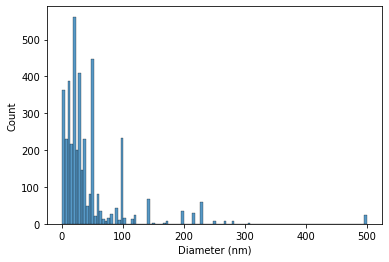

In [9]:
# Ограничение диаметра
sns.histplot(df['Diameter (nm)'])

In [10]:
df['Diameter (nm)'] = df['Diameter (nm)'].apply(lambda x: clamp(x, 0, 300))

In [11]:
# Добавление описания формы НЧ
get_bounds(encoded, 'Diameter (nm)')

In [12]:
# Скейлинг БД
from sklearn.preprocessing import MinMaxScaler

encoded, _ = scale_by_columns(encoded, MinMaxScaler)

In [13]:
# Заполнение пропусков
fill_with_mode(encoded)

In [14]:
# Попытки предсказать целевую переменную и выкинуть
# как можно больше столбцов
from sklearn.model_selection import train_test_split

to_drop = [
    'Cell_Viability (%)', 'Aspect_Ratio', 'Shape'
]

x, y = encoded.drop(to_drop, axis=1), encoded['Cell_Viability (%)']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)

In [15]:
# Обучение
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor().fit(x_train, y_train)
rfr.score(x_test, y_test)

0.8103491866176802

<BarContainer object of 21 artists>

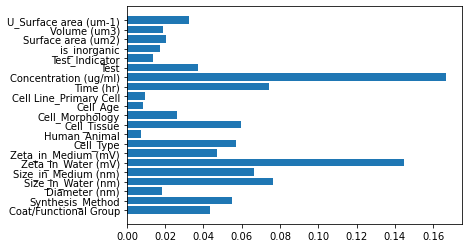

In [16]:
plt.barh(x.columns, rfr.feature_importances_)

In [17]:
# Неплохой результат!